In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
os.chdir('/media/shubham/3AA25FBFA25F7DF7/AV')
import json
import os
os.chdir('/media/shubham/3AA25FBFA25F7DF7/Data Science/IndiaHack17/hotstar')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import re
from sklearn.metrics import roc_auc_score

In [2]:
## reading data
train = pd.read_json('train_data.json',orient="index")
test = pd.read_json('test_data.json',orient='index')

In [24]:
train.head()

,cities,dow,genres,segment,titles,tod
train-1,"gurgaon:55494,delhi:31892","1:3412,3:15878,2:1737,5:10975,4:20974,7:17820,...","Cricket:82379,Kabaddi:255,Reality:4751",neg,"Top Raids: Haryana vs Services SCB:103,Day 4: ...","10:26,13:331,12:323,20:21864,21:16233,17:7953,..."
train-10,"delhi:5862,nagar:8916,mumbai:1593","1:5745,3:3025,2:3346,5:123,4:3007,7:1108,6:10","Cricket:15640,Wildlife:730",neg,"Dhoni Quits Captaincy:148,Day 4: India Move in...","11:1661,10:384,20:401,21:798,22:221,16:525,19:..."
train-100,navi mumbai:4142,3:4142,"LiveTV:13,Football:4129",neg,"Star Sports 4:13,Manchester United vs Everton:...","1:1207,0:2406,2:529"
train-1000,"new delhi:4131,chennai:2878,navi mumbai:1339","1:658,3:5867,5:413,4:1339,7:71","TalkShow:658,Cricket:7690",neg,"SRH vs RCB:701,KKR vs KXIP:1042,MI vs SRH:2288...","11:71,20:2417,21:1042,23:2288,19:1872,8:658"
train-10000,"gurgaon:6077,chennai:4055","1:1641,2:480,4:1445,7:1663,6:4900","Drama:5503,Cricket:3283,Reality:1345",neg,"MI vs KKR:304,Yeh Rishta Kya Kehlata Hai:5449,...","20:158,22:4139,17:67,23:1510,19:288,18:56,0:23..."


In [3]:
#set index
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [4]:
#Encode Target Variable
train = train.replace({'segment':{'pos':1,'neg':0}})

In [5]:
train['segment'].value_counts()/train.shape[0]

0    0.923725
1    0.076275
Name: segment, dtype: float64

In [6]:
train['g1'] = [re.sub(pattern='\:\d+', repl='', string=x) for x in train['genres']]
train['g1'] = train['g1'].apply(lambda x : x.split(','))

train['g2'] = [re.sub(pattern='\:\d+', repl='', string=x) for x in train['dow']]
train['g2'] = train['g2'].apply(lambda x : x.split(','))

In [7]:
t1 = pd.Series(train['g1']).apply(frozenset).to_frame(name='t_genre')
t2 = pd.Series(train['g2']).apply(frozenset).to_frame(name='t_dow')

In [8]:
for t_genre in frozenset.union(*t1.t_genre):
    t1[t_genre] = t1.apply(lambda _: int(t_genre in _.t_genre), axis=1)

In [9]:
for t_dow in frozenset.union(*t2.t_dow):
    t2[t_dow] = t2.apply(lambda _: int(t_dow in _.t_dow), axis = 1)

In [10]:
train_data = train

In [11]:
train_data = pd.concat([train_data.reset_index(drop=True), t1], axis=1)
train_data = pd.concat([train_data.reset_index(drop=True), t2], axis=1)

In [12]:
test_data = test
test_data['g1'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in test_data['genres']]
test_data['g1'] = test_data['g1'].apply(lambda x: x.split(','))

test_data['g2'] = [re.sub(pattern='\:\d+', repl='', string = x) for x in test_data['dow']]
test_data['g2'] = test_data['g2'].apply(lambda x: x.split(','))

t1_te = pd.Series(test_data['g1']).apply(frozenset).to_frame(name='t_genre')
t2_te = pd.Series(test_data['g2']).apply(frozenset).to_frame(name='t_dow')

In [13]:
for t_genre in frozenset.union(*t1_te.t_genre):
    t1_te[t_genre] = t1_te.apply(lambda _: int(t_genre in _.t_genre), axis=1)

In [14]:
for t_dow in frozenset.union(*t2_te.t_dow):
    t2_te[t_dow] = t2_te.apply(lambda _: int(t_dow in _.t_dow), axis = 1)

In [15]:
test_data = pd.concat([test_data.reset_index(drop=True), t1_te], axis=1)
test_data = pd.concat([test_data.reset_index(drop=True), t2_te], axis=1)


In [16]:
#the rows aren't list exactly. They are object, so we convert them to list and extract the watch time
w1 = train_data['titles']
w1 = w1.str.split(',')

#create a nested list of numbers
main = []
for i in np.arange(train_data.shape[0]):
    d1 = w1[i]
    nest = []
    nest = [re.sub(pattern = '.*\:', repl=' ', string= d1[k]) for k in list(np.arange(len(d1)))]
    main.append(nest)

In [17]:
blanks = []
for i in np.arange(len(main)):
    if '' in main[i]:
        print ("{} blanks found".format(len(blanks)))
        blanks.append(i)
        
#replacing blanks with 0
for i in blanks:
    main[i] = [x.replace('','0') for x in main[i]]
    
#converting string to integers
main = [[int(y) for y in x] for x in main]

#adding the watch time
tosum = []
for i in np.arange(len(main)):
    s = sum(main[i])
    tosum.append(s)

0 blanks found
1 blanks found
2 blanks found
3 blanks found
4 blanks found
5 blanks found
6 blanks found
7 blanks found
8 blanks found
9 blanks found
10 blanks found
11 blanks found
12 blanks found
13 blanks found
14 blanks found
15 blanks found
16 blanks found
17 blanks found
18 blanks found
19 blanks found
20 blanks found
21 blanks found
22 blanks found
23 blanks found
24 blanks found
25 blanks found
26 blanks found
27 blanks found
28 blanks found
29 blanks found
30 blanks found
31 blanks found
32 blanks found
33 blanks found
34 blanks found
35 blanks found
36 blanks found
37 blanks found
38 blanks found
39 blanks found
40 blanks found
41 blanks found
42 blanks found
43 blanks found
44 blanks found
45 blanks found


In [18]:
train_data['title_sum'] = tosum

In [19]:
#making changes in test data
w1_te = test_data['titles']
w1_te = w1_te.str.split(',')

In [20]:
main_te = []
for i in np.arange(test_data.shape[0]):
    d1 = w1_te[i]
    nest = []
    nest = [re.sub(pattern = '.*\:', repl=' ', string= d1[k]) for k in list(np.arange(len(d1)))]
    main_te.append(nest)

In [21]:
blanks_te = []
for i in np.arange(len(main_te)):
    if '' in main_te[i]:
        print ("{} blanks found".format(len(blanks_te)))
        blanks_te.append(i)
        
#replacing blanks with 0
for i in blanks_te:
    main_te[i] = [x.replace('','0') for x in main_te[i]]
    
#converting string to integers
main_te = [[int(y) for y in x] for x in main_te]

#adding the watch time
tosum_te = []
for i in np.arange(len(main_te)):
    s = sum(main_te[i])
    tosum_te.append(s)


0 blanks found
1 blanks found
2 blanks found
3 blanks found
4 blanks found
5 blanks found
6 blanks found
7 blanks found
8 blanks found
9 blanks found
10 blanks found
11 blanks found


In [22]:
test_data['title_sum'] = tosum_te

In [23]:
#count variables
def wcount(p):
    return p.count(',')+1

In [24]:
train_data['title_count'] = train_data['titles'].map(wcount)
train_data['genres_count'] = train_data['genres'].map(wcount)
train_data['cities_count'] = train_data['cities'].map(wcount)
train_data['tod_count'] = train_data['tod'].map(wcount)
train_data['dow_count'] = train_data['dow'].map(wcount)


test_data['title_count'] = test_data['titles'].map(wcount)
test_data['genres_count'] = test_data['genres'].map(wcount)
test_data['cities_count'] = test_data['cities'].map(wcount)
test_data['tod_count'] = test_data['tod'].map(wcount)
test_data['dow_count'] = test_data['dow'].map(wcount)

In [25]:
test_id = test_data['index']
train_data.drop(['index','cities','dow','genres','titles','tod','g1','g2','t_genre','t_dow'], inplace=True, axis=1)
test_data.drop(['index','cities','dow','genres','titles','tod','g1','g2','t_genre','t_dow'], inplace=True, axis=1)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split

/home/shubham/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/shubham/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [27]:
target = train_data['segment']
training = train_data.drop('segment',axis=1)

In [28]:
#train final model
rf_model = RandomForestClassifier(n_estimators=500,max_depth=12, max_features=10)
rf_model.fit(training, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [86]:
#make prediction
rf_pred = rf_model.predict_proba(test_data)

In [87]:
#make submission file and submit
columns = ['segment']
sub = pd.DataFrame(data=rf_pred[:,1], columns=columns)
sub['ID'] = test_id
sub = sub[['ID','segment']]
sub.to_csv("sub_hot.csv", index=False)

In [28]:
train_data.shape
features = training.columns.values

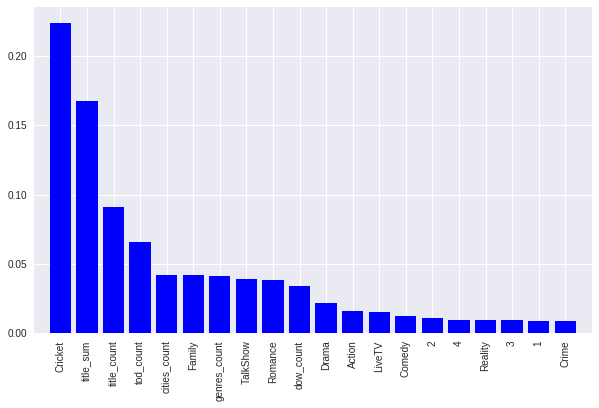

In [29]:
### plotting importances
features = training.columns.values
imp = rf_model.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(10,6))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

In [92]:
x_train,x_test,y_train,y_test = train_test_split(training,target,random_state=1)

In [107]:
rf_model = RandomForestClassifier(n_estimators=200,max_depth=8, max_features=10)
rf_model.fit(x_train,y_train)
pred= rf_model.predict_proba(x_test)
roc_auc_score(y_test,pred[:,1])

0.79221022295474108

In [113]:
rf_model.fit(x_train[features[indices]],y_train)
pred= rf_model.predict_proba(x_test[features[indices]])
roc_auc_score(y_test,pred[:,1])

0.79245195229125942

In [114]:
## using only 20 important features
rf_model = RandomForestClassifier(n_estimators=500,max_depth=12, max_features=10)
rf_model.fit(training[features[indices]], target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [115]:
rf_pred = rf_model.predict_proba(test_data[features[indices]])
#make submission file and submit
columns = ['segment']
sub = pd.DataFrame(data=rf_pred[:,1], columns=columns)
sub['ID'] = test_id
sub = sub[['ID','segment']]
sub.to_csv("sub_hot.csv", index=False)

In [29]:
##stacking into 3
train1 = train_data.loc[:64999,]
train2 = train_data.loc[65000:130000,]
train3 = train_data.loc[130001:,]

In [30]:
target1 = train1['segment']
target2 = train2['segment']
target3 = train3['segment']

In [35]:
## combining one and two 
train12 = train1.append(train2)
target12 = target1.append(target2)
model = RandomForestClassifier(n_estimators=300,max_depth=8, max_features=10)
model.fit(train12[features[indices]],target12)
pred1 = model.predict_proba(train3[features[indices]])
roc_auc_score(target3,pred1[:,1])

0.80087176349465383

In [36]:
pred_t1 = model.predict_proba(test_data[features[indices]])

In [37]:
## combining 2 and 3
train23 = train2.append(train3)
target23 = target2.append(target3)
model = RandomForestClassifier(n_estimators=300,max_depth=8, max_features=10)
model.fit(train23[features[indices]],target23)
pred2 = model.predict_proba(train1[features[indices]])
roc_auc_score(target1,pred2[:,1])

0.78799001240489419

In [38]:
pred_t2 = model.predict_proba(test_data[features[indices]])

In [39]:
## combining 1 and 3
train13 = train1.append(train3)
target13 = target1.append(target3)
model = RandomForestClassifier(n_estimators=300,max_depth=8, max_features=10)
model.fit(train13[features[indices]],target13)
pred3 = model.predict_proba(train2[features[indices]])
roc_auc_score(target2,pred3[:,1])

0.80354372024777876

In [40]:
pred_t3 = model.predict_proba(test_data[features[indices]])

In [41]:
train1['prob'] = pred2[:,1]
train2['prob'] = pred3[:,1]
train3['prob'] = pred1[:,1]
test_data['prob'] = pred_t1[:,1] + pred_t2[:,1] + pred_t3[:,1]

/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [42]:
features[indices] = np.append(features[indices],['prob'])

/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  """Entry point for launching an IPython kernel.


In [43]:
training = train1.append(train2).append(train3)

In [44]:
rf_model = RandomForestClassifier(n_estimators=500,max_depth=12, max_features=10)
rf_model.fit(training[features[indices]], target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [45]:
rf_pred = rf_model.predict_proba(test_data[features[indices]])
#make submission file and submit
columns = ['segment']
sub = pd.DataFrame(data=rf_pred[:,1], columns=columns)
sub['ID'] = test_id
sub = sub[['ID','segment']]
sub.to_csv("sub_hot.csv", index=False)

In [34]:
## using xgboost model
import xgboost as xgb
#base_score= np.mean(training['segment'])
xgb_para = {
    #'n_trees':500,
    'eta':0.05,
    'max_depth':6,
    'subsample':0.75,
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    #'base-score': base_score
  # 'colsample_bytree':0.8,
   #'min_child_weight':1
}

In [35]:
#Dmatrix
dtrain = xgb.DMatrix(training[features[indices]], target)
dtest = xgb.DMatrix(test_data[features[indices]])

In [36]:
#xgboost cv
cv_result = xgb.cv(xgb_para,
                   dtrain,
                   num_boost_round=200,
                   early_stopping_rounds=50,
                   verbose_eval=50,
                   show_stdv=False)
num_boost_rounds = len(cv_result)
print (num_boost_rounds)

model = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)

[0]	train-auc:0.787776	test-auc:0.781806
[50]	train-auc:0.809785	test-auc:0.79919
[100]	train-auc:0.818465	test-auc:0.801403
[150]	train-auc:0.825521	test-auc:0.801886
136


In [52]:
pred = model.predict(dtest)
#make submission file and submit
columns = ['segment']
sub = pd.DataFrame(data=pred, columns=columns)
sub['ID'] = test_id
sub = sub[['ID','segment']]
sub.to_csv("sub_hot.csv", index=False)

In [56]:
## stacking using xgb

In [37]:
##stacking into 3
train1 = train_data.loc[:64999,]
train2 = train_data.loc[65000:130000,]
train3 = train_data.loc[130001:,]

In [38]:
target1 = train1['segment']
target2 = train2['segment']
target3 = train3['segment']

In [39]:
## combining one and two 
train12 = train1.append(train2)
target12 = target1.append(target2)
#Dmatrix
dtrain = xgb.DMatrix(train12[features[indices]], target12)
dtest = xgb.DMatrix(train3[features[indices]])

model1 = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)
pred1 = model1.predict(dtest)
roc_auc_score(target3,pred1)

0.80569785557634388

In [40]:
dtest = xgb.DMatrix(test_data[features[indices]])
pred_t1 = model1.predict(dtest)

In [41]:
## combining one and three 
train13 = train1.append(train3)
target13 = target1.append(target3)
#Dmatrix
dtrain = xgb.DMatrix(train13[features[indices]], target13)
dtest = xgb.DMatrix(train2[features[indices]])

model2 = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)
pred2 = model2.predict(dtest)
roc_auc_score(target2,pred2)

0.80717403429085999

In [42]:
dtest = xgb.DMatrix(test_data[features[indices]])
pred_t2 = model2.predict(dtest)

In [43]:
## combining two and three 
train23 = train2.append(train3)
target23 = target2.append(target3)
#Dmatrix
dtrain = xgb.DMatrix(train23[features[indices]], target23)
dtest = xgb.DMatrix(train1[features[indices]])

model3 = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)
pred3 = model3.predict(dtest)
roc_auc_score(target1,pred3)

0.79260525583593366

In [44]:
dtest = xgb.DMatrix(test_data[features[indices]])
pred_t3 = model3.predict(dtest)

In [45]:
train1['prob'] = pred3
train2['prob'] = pred2
train3['prob'] = pred1
test_data['prob'] = pred_t1 + pred_t2 + pred_t3

/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [57]:
indices = np.append(indices,49)

In [58]:
features = train1.columns.values
features[indices]

array(['Table Tennis', '3', 'title_sum', 'cities_count', 'genres_count',
       'Science', 'title_count', 'NA', 'Reality', 'tod_count', 'Kids',
       'Crime', 'Formula1', 'Tennis', '5', '7', 'TalkShow', '1', '6',
       'Travel', 'prob'], dtype=object)

In [59]:
training = train1.append(train2).append(train3)

In [72]:
## final xgb model

In [60]:
#Dmatrix
dtrain = xgb.DMatrix(training[features[indices]], target)
dtest = xgb.DMatrix(test_data[features[indices]])

In [61]:
#xgboost cv
cv_result = xgb.cv(xgb_para,
                   dtrain,
                   num_boost_round=200,
                   early_stopping_rounds=50,
                   verbose_eval=50,
                   show_stdv=False)
num_boost_rounds = len(cv_result)
print (num_boost_rounds)

model = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)

[0]	train-auc:0.799933	test-auc:0.796599
[50]	train-auc:0.812181	test-auc:0.800905
[100]	train-auc:0.818615	test-auc:0.801062
77


In [1]:
pred = model.predict(dtest)
#make submission file and submit
columns = ['segment']
sub = pd.DataFrame(data=pred, columns=columns)
sub['ID'] = test_id
sub = sub[['ID','segment']]
sub.to_csv("sub_hot.csv", index=False)

NameError: name 'model' is not defined